<a href="https://colab.research.google.com/github/MOTURUPRAVEENBHARGAV/bert_models/blob/main/BERT_Pre_Trained_MULTI_CLASS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

For Reference: https://github.com/sumitc29/NLP/tree/master/BERT%20Text%20classification%20model

In [ ]:

"""importing all packages"""
import numpy as np 
import pandas as pd
import re
import gc
import os
import fileinput
import string
import tensorflow as tf
import zipfile
import datetime
import sys
from tqdm  import tqdm
tqdm.pandas()
from nltk.tokenize import wordpunct_tokenize
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score, roc_auc_score

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, LSTM, Conv1D, MaxPooling1D, Dropout, Activation
from tensorflow.keras.layers import Bidirectional,Activation, Dense, Dropout, Embedding, Flatten, Conv1D, MaxPooling1D, LSTM, Input
from sklearn.metrics import classification_report

from bert import modeling
from bert import optimization
from  bert import run_classifier

import tokenization
import time
%time

CPU times: user 2 µs, sys: 1 µs, total: 3 µs
Wall time: 5.01 µs


/usr/local/lib/python3.7/dist-packages/tqdm/std.py:658: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [ ]:
# import tensorflow as tf

# print(tf.__version__)

# !pip uninstall tensorflow==2.2.0

# !pip install tensorflow==1.15.0

# !pip install bert-tensorflow

In [ ]:
"""loading pretrained BERT classifier alongwith other files"""
!wget https://storage.googleapis.com/bert_models/2018_10_18/uncased_L-12_H-768_A-12.zip
!wget https://raw.githubusercontent.com/google-research/bert/master/modeling.py 
!wget https://raw.githubusercontent.com/google-research/bert/master/optimization.py 
!wget https://raw.githubusercontent.com/google-research/bert/master/run_classifier.py 
!wget https://raw.githubusercontent.com/google-research/bert/master/tokenization.py 

--2021-03-15 12:45:46--  https://storage.googleapis.com/bert_models/2018_10_18/uncased_L-12_H-768_A-12.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 64.233.189.128, 74.125.203.128, 2404:6800:4008:c02::80, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|64.233.189.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 407727028 (389M) [application/zip]
Saving to: ‘uncased_L-12_H-768_A-12.zip’

uncased_L-12_H-768_ 100%[===================>] 388.84M  78.1MB/s    in 5.0s    

2021-03-15 12:45:51 (78.1 MB/s) - ‘uncased_L-12_H-768_A-12.zip’ saved [407727028/407727028]



In [ ]:
  """Extracting zip files into model folder"""
import zipfile
folder = '/content/drive/MyDrive/Sentiment Analysis_Preskale/model_folder'
with zipfile.ZipFile("uncased_L-12_H-768_A-12.zip","r") as zip_ref:
    zip_ref.extractall(folder)

In [ ]:
import pathlib
pathlib.Path(folder).parent.absolute()

PosixPath('/content/drive/MyDrive/Sentiment Analysis_Preskale')

In [ ]:
    
"""creating additional folder in model folder for convenience"""
BERT_MODEL = 'uncased_L-12_H-768_A-12'
BERT_PRETRAINED_DIR = f'{folder}/uncased_L-12_H-768_A-12'
OUTPUT_DIR = f'{folder}/outputs'
print(f'>> Model output directory: {OUTPUT_DIR}')
print(f'>>  BERT pretrained directory: {BERT_PRETRAINED_DIR}')

>> Model output directory: /content/drive/MyDrive/Sentiment Analysis_Preskale/model_folder/outputs
>>  BERT pretrained directory: /content/drive/MyDrive/Sentiment Analysis_Preskale/model_folder/uncased_L-12_H-768_A-12


In [ ]:
data=pd.read_csv("/content/drive/My Drive/Sentiment Analysis_Preskale/EDA FOR REVIEWS DATASET/Cleaned_reviews.csv",index_col="Unnamed: 0")
data.head()

,userName,content,score,Polarity,clean_text,common_words
0,Andrew Thomas,Update: After getting a response from the deve...,1,Negative,update getting response developer would change...,"['update', 'getting', 'response', 'developer',..."
1,Craig Haines,Used it for a fair amount of time without any ...,1,Negative,used fair amount time without problem suddenly...,"['used', 'fair', 'amount', 'time', 'without', ..."
2,steven adkins,Your app sucks now!!!!! Used to be good but no...,1,Negative,app suck used good doesnt update physically op...,"['app', 'suck', 'used', 'good', 'doesnt', 'upd..."
3,Lars Panzerbjørn,"It seems OK, but very basic. Recurring tasks n...",1,Negative,seems ok basic recurring task need work actual...,"['seems', 'ok', 'basic', 'recurring', 'task', ..."
4,Scott Prewitt,Absolutely worthless. This app runs a prohibit...,1,Negative,absolutely worthless app run prohibitively clu...,"['absolutely', 'worthless', 'app', 'run', 'pro..."


In [ ]:
data=data.loc[:,["content","Polarity","clean_text"]]
data.columns

Index(['content', 'Polarity', 'clean_text'], dtype='object')

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15746 entries, 0 to 15745
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   content     15746 non-null  object
 1   Polarity    15746 non-null  object
 2   clean_text  15737 non-null  object
dtypes: object(3)
memory usage: 492.1+ KB


Some columns which i perceived are not useful for the modeling purpose and the target columns "Polarity" is essential to be encoded

In [ ]:
data.isnull().sum()

content       0
Polarity      0
clean_text    9
dtype: int64

In [ ]:
data.dropna(inplace=True)
data.reset_index(inplace=True,drop=True)
data.head()

,content,Polarity,clean_text
0,Update: After getting a response from the deve...,Negative,update getting response developer would change...
1,Used it for a fair amount of time without any ...,Negative,used fair amount time without problem suddenly...
2,Your app sucks now!!!!! Used to be good but no...,Negative,app suck used good doesnt update physically op...
3,"It seems OK, but very basic. Recurring tasks n...",Negative,seems ok basic recurring task need work actual...
4,Absolutely worthless. This app runs a prohibit...,Negative,absolutely worthless app run prohibitively clu...


Label Encoding the 'Polarity' column

In [ ]:
# cond=[df.Polarity=="Positive",df.Polarity=="Neutral",df.Polarity=="Negative"]
# choice=[2,1,0]
# data.Polarity=np.select(cond,choice)
# data.Polarity.head()

0    0
1    0
2    0
3    0
4    0
Name: Polarity, dtype: int64

# OR


In [ ]:
from sklearn.preprocessing import LabelEncoder
le=LabelEncoder()
data["Polarity"]=le.fit_transform(data["Polarity"])
data.head()

,content,Polarity,clean_text
0,Update: After getting a response from the deve...,0,update getting response developer would change...
1,Used it for a fair amount of time without any ...,0,used fair amount time without problem suddenly...
2,Your app sucks now!!!!! Used to be good but no...,0,app suck used good doesnt update physically op...
3,"It seems OK, but very basic. Recurring tasks n...",0,seems ok basic recurring task need work actual...
4,Absolutely worthless. This app runs a prohibit...,0,absolutely worthless app run prohibitively clu...


In [ ]:
data.Polarity.value_counts().rename({2:'Positive',0:'Negative',1:'Neutral'})

Positive    5674
Neutral     5037
Negative    5026
Name: Polarity, dtype: int64

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data["clean_text"].values, data["Polarity"].values, test_size=0.2, random_state=42,stratify= data.Polarity.values)

In [ ]:
print(f"X_train.shape: {X_train.shape}")
print(f"y_train.shape: {y_train.shape}")
print(f"X_test.shape: {X_test.shape}")
print(f"y_test.shape: {y_test.shape}")

X_train.shape: (12589,)
y_train.shape: (12589,)
X_test.shape: (3148,)
y_test.shape: (3148,)


In [ ]:
# data['data_type']= ['not_set']*data.shape[0]

# data.loc[X_train, 'data_type']= 'train'
# data.loc[X_test, 'data_type'] = 'val'


# data.groupby(['content','Polarity','data_type']).count()

In [ ]:
def create_examples(lines, set_type, labels=None):
#Generate data for the BERT model
    guid = f'{set_type}'
    examples = []
    if guid == 'train':
        for line, label in zip(lines, labels):
            text_a = line
            label = str(label)
            """Creating single training/test example for simple sequence classification."""
            examples.append(run_classifier.InputExample(guid=guid, text_a=text_a, text_b=None, label=label))
    else:
        for line in lines:
            text_a = line
            label = '0'
            examples.append(run_classifier.InputExample(guid=guid, text_a=text_a, text_b=None, label=label))
    return examples

In [ ]:
# Model Hyper Parameters
TRAIN_BATCH_SIZE = 32
EVAL_BATCH_SIZE = 8
LEARNING_RATE = 1e-5
NUM_TRAIN_EPOCHS = 3.0
WARMUP_PROPORTION = 0.1
MAX_SEQ_LENGTH = 50
# Model configs
SAVE_CHECKPOINTS_STEPS = 100000 #if you wish to finetune a model on a larger dataset, use larger interval
# each checpoint weights about 1,5gb
ITERATIONS_PER_LOOP = 100000
NUM_TPU_CORES = 8
VOCAB_FILE = os.path.join(BERT_PRETRAINED_DIR, 'vocab.txt')
CONFIG_FILE = os.path.join(BERT_PRETRAINED_DIR, 'bert_config.json')
INIT_CHECKPOINT = os.path.join(BERT_PRETRAINED_DIR, 'bert_model.ckpt')
DO_LOWER_CASE = BERT_MODEL.startswith('uncased')


In [ ]:
label_list = [str(num) for num in range(data['Polarity'].nunique())]
tokenizer = tokenization.FullTokenizer(vocab_file=VOCAB_FILE, do_lower_case=DO_LOWER_CASE)

In [ ]:
"""Creating input in the form of Text sequence classification"""
train_examples = create_examples(X_train, 'train', labels=y_train)

In [ ]:
tpu_cluster_resolver = None #Since training will happen on GPU, we won't need a cluster resolver
#TPUEstimator also supports training on CPU and GPU. You don't need to define a separate tf.estimator.Estimat

In [ ]:
"""Making all running configurations"""
run_config = tf.contrib.tpu.RunConfig(
    cluster=tpu_cluster_resolver,
    model_dir=OUTPUT_DIR,
    save_checkpoints_steps=SAVE_CHECKPOINTS_STEPS,
    tpu_config=tf.contrib.tpu.TPUConfig(
        iterations_per_loop=ITERATIONS_PER_LOOP,
        num_shards=NUM_TPU_CORES,
        per_host_input_for_training=tf.contrib.tpu.InputPipelineConfig.PER_HOST_V2))

"""this much of total iterations will be called"""
num_train_steps = int(len(train_examples) / TRAIN_BATCH_SIZE * NUM_TRAIN_EPOCHS)

"""Why to use this"""
num_warmup_steps = int(num_train_steps * WARMUP_PROPORTION)

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



In [ ]:
model_fn = run_classifier.model_fn_builder(
    bert_config=modeling.BertConfig.from_json_file(CONFIG_FILE),
    num_labels=len(label_list),
    init_checkpoint=INIT_CHECKPOINT,
    learning_rate=LEARNING_RATE,
    num_train_steps=num_train_steps,
    num_warmup_steps=num_warmup_steps,
    use_tpu=False, #If False training will fall on CPU or GPU, depending on what is available  
    use_one_hot_embeddings=True)

In [ ]:
estimator = tf.contrib.tpu.TPUEstimator(
    use_tpu=False, #If False training will fall on CPU or GPU, depending on what is available 
    model_fn=model_fn,
    config=run_config,
    train_batch_size=TRAIN_BATCH_SIZE,
    eval_batch_size=EVAL_BATCH_SIZE)

INFO:tensorflow:Using config: {'_model_dir': '/content/drive/MyDrive/Sentiment Analysis_Preskale/model_folder/outputs', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': 100000, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': None, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f36d87f0d50>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1, '_tpu_config': TPUConfig(iterations

In [ ]:
'''Since the model is pretrained why do we need to train it again'''
print('Please wait...')
"""preparing training data """
train_features = run_classifier.convert_examples_to_features(train_examples, label_list, MAX_SEQ_LENGTH, tokenizer)
print('>> Started training at {} '.format(datetime.datetime.now()))
print('  Num examples = {}'.format(len(train_examples)))
print('  Batch size = {}'.format(TRAIN_BATCH_SIZE))
tf.logging.info("  Num steps = %d", num_train_steps)
"""Here run classifier the the classifier from the bert which will get trained and will be responsible for prediction as well"""
train_input_fn = run_classifier.input_fn_builder(
    features=train_features,
    seq_length=MAX_SEQ_LENGTH,
    is_training=True,
    drop_remainder=True)
estimator.train(input_fn=train_input_fn, max_steps=num_train_steps)
print('>> Finished training at {}'.format(datetime.datetime.now()))

Please wait...
INFO:tensorflow:Writing example 0 of 12589
INFO:tensorflow:*** Example ***
INFO:tensorflow:guid: train
INFO:tensorflow:tokens: [CLS] still missing bunch essential feature like send reminder user list recurring reminder certain time day bad [UNK] really enjoyed ui feature must [SEP]
INFO:tensorflow:input_ids: 101 2145 4394 9129 6827 3444 2066 4604 14764 5310 2862 10694 14764 3056 2051 2154 2919 100 2428 5632 21318 3444 2442 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
INFO:tensorflow:label: 0 (id = 0)
INFO:tensorflow:*** Example ***
INFO:tensorflow:guid: train
INFO:tensorflow:tokens: [CLS] developer done amazing job app annoying pop ##ups ad bug overall flawless experience four year since iv ##e used im excit

In [ ]:

def input_fn_builder(features, seq_length, is_training, drop_remainder):
  """Creates an `input_fn` closure to be passed to TPUEstimator."""
  """This is used to make the proper format of the prediction variable"""

  all_input_ids = []
  all_input_mask = []
  all_segment_ids = []
  all_label_ids = []

  for feature in features:
    all_input_ids.append(feature.input_ids)
    all_input_mask.append(feature.input_mask)
    all_segment_ids.append(feature.segment_ids)
    all_label_ids.append(feature.label_id)

  def input_fn(params):
    """The actual input function."""
    print(params)
    batch_size = 500

    num_examples = len(features)

    d = tf.data.Dataset.from_tensor_slices({
        "input_ids":
            tf.constant(
                all_input_ids, shape=[num_examples, seq_length],
                dtype=tf.int32),
        "input_mask":
            tf.constant(
                all_input_mask,
                shape=[num_examples, seq_length],
                dtype=tf.int32),
        "segment_ids":
            tf.constant(
                all_segment_ids,
                shape=[num_examples, seq_length],
                dtype=tf.int32),
        "label_ids":
            tf.constant(all_label_ids, shape=[num_examples], dtype=tf.int32),
    })

    if is_training:
      d = d.repeat()
      d = d.shuffle(buffer_size=100)

    d = d.batch(batch_size=batch_size, drop_remainder=drop_remainder)
    return d

  return input_fn


In [ ]:
predict_examples = create_examples(X_test, 'test')

In [ ]:
predict_features = run_classifier.convert_examples_to_features(predict_examples, label_list, MAX_SEQ_LENGTH, tokenizer)

INFO:tensorflow:Writing example 0 of 3148
INFO:tensorflow:*** Example ***
INFO:tensorflow:guid: test
INFO:tensorflow:tokens: [CLS] excellent app continuous improvement make app top productivity category [SEP]
INFO:tensorflow:input_ids: 101 6581 10439 7142 7620 2191 10439 2327 15836 4696 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
INFO:tensorflow:label: 0 (id = 0)
INFO:tensorflow:*** Example ***
INFO:tensorflow:guid: test
INFO:tensorflow:tokens: [CLS] planner isn ##t saving day event see event month view open day event show [SEP]
INFO:tensorflow:input_ids: 101 24555 3475 2102 7494 2154 2724 2156 2724 3204 3193 2330 2154 2724 2265 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

In [ ]:
"""predictions and acuracy"""
predict_input_fn = input_fn_builder(
    features=predict_features,
    seq_length=MAX_SEQ_LENGTH,
    is_training=False,
    drop_remainder=False)

result = estimator.predict(input_fn=predict_input_fn)

In [ ]:
result

<generator object TPUEstimator.predict at 0x7f36d87f62d0>

In [ ]:
preds = []
for prediction in result:
      preds.append(np.argmax(prediction['probabilities']))

{}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Running infer on CPU
INFO:tensorflow:*** Features ***
INFO:tensorflow:  name = input_ids, shape = (?, 50)
INFO:tensorflow:  name = input_mask, shape = (?, 50)
INFO:tensorflow:  name = label_ids, shape = (?,)
INFO:tensorflow:  name = segment_ids, shape = (?, 50)
INFO:tensorflow:**** Trainable Variables ****
INFO:tensorflow:  name = bert/embeddings/word_embeddings:0, shape = (30522, 768), *INIT_FROM_CKPT*
INFO:tensorflow:  name = bert/embeddings/token_type_embeddings:0, shape = (2, 768), *INIT_FROM_CKPT*
INFO:tensorflow:  name = bert/embeddings/position_embeddings:0, shape = (512, 768), *INIT_FROM_CKPT*
INFO:tensorflow:  name = bert/embeddings/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*
INFO:tensorflow:  name = bert/embeddings/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*
INFO:tensorflow:  name = bert/encoder/layer_0/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*
INFO:tensorflow:  name = bert/encoder/l

In [ ]:
from sklearn.metrics import accuracy_score
print("Accuracy of BERT is:",accuracy_score(y_test,preds))
print(classification_report(y_test,preds))

Accuracy of BERT is: 0.7013977128335451
              precision    recall  f1-score   support

           0       0.72      0.72      0.72      1005
           1       0.58      0.58      0.58      1008
           2       0.80      0.79      0.79      1135

    accuracy                           0.70      3148
   macro avg       0.70      0.70      0.70      3148
weighted avg       0.70      0.70      0.70      3148



In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

In [ ]:
#plotting confusion matrix
import matplotlib.pyplot as plt
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='BERT_TF Confusion matrix',
                          cmap=plt.cm.YlOrRd):
    """
    See full source and example: 
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title,fontsize=17)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="right",
                 color="White" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

Confusion matrix, without normalization


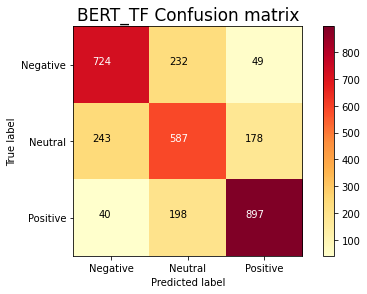

In [ ]:
cm= confusion_matrix(y_test,preds)
plot_confusion_matrix(cm, ['Negative','Neutral','Positive'])


In [ ]:
import pickle as pk
file="/content/drive/MyDrive/Sentiment Analysis_Preskale/estimator.pkl"
estimator = pk.dump(estimator,open(file, 'w'))

AttributeError: ignored